In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Reading the Images

In [ ]:
import os
os.listdir('/kaggle/input/butterfly-image-classification')

['Training_set.csv', 'Testing_set.csv', 'test', 'train']

In [ ]:
train_df = pd.read_csv(r'/kaggle/input/butterfly-image-classification/Training_set.csv')
test_df = pd.read_csv(r'/kaggle/input/butterfly-image-classification/Testing_set.csv')

train_dir = '/kaggle/input/butterfly-image-classification/train'
test_dir = '/kaggle/input/butterfly-image-classification/test'

In [ ]:
train_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [ ]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

In [ ]:
train_df.shape

(6499, 2)

In [ ]:
test_df.shape

(2786, 1)

In [ ]:
train_df.dtypes

filename    object
label       object
dtype: object

In [ ]:
test_df.dtypes

filename    object
dtype: object

In [ ]:
size = 224

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
).flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    X_col='filename',
    y_col='label',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training',
    seed=42,
    shuffle=True
)


Found 6499 validated image filenames belonging to 75 classes.


In [ ]:
mapping = train_gen.class_indices
train_df['label'] = train_df['label'].map(mapping)

In [ ]:
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = 0.1
).flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    X_col='filename',
    y_col='label',
    target_size=(size,size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=42,
    shuffle=False
)

Found 649 validated image filenames belonging to 75 classes.


In [ ]:
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    X_col='filename',
    y_col=None,
    target_size=(size,size),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 2786 validated image filenames.


In [ ]:
train_gen.class_indices

{'ADONIS': 0,
 'AFRICAN GIANT SWALLOWTAIL': 1,
 'AMERICAN SNOOT': 2,
 'AN 88': 3,
 'APPOLLO': 4,
 'ATALA': 5,
 'BANDED ORANGE HELICONIAN': 6,
 'BANDED PEACOCK': 7,
 'BECKERS WHITE': 8,
 'BLACK HAIRSTREAK': 9,
 'BLUE MORPHO': 10,
 'BLUE SPOTTED CROW': 11,
 'BROWN SIPROETA': 12,
 'CABBAGE WHITE': 13,
 'CAIRNS BIRDWING': 14,
 'CHECQUERED SKIPPER': 15,
 'CHESTNUT': 16,
 'CLEOPATRA': 17,
 'CLODIUS PARNASSIAN': 18,
 'CLOUDED SULPHUR': 19,
 'COMMON BANDED AWL': 20,
 'COMMON WOOD-NYMPH': 21,
 'COPPER TAIL': 22,
 'CRECENT': 23,
 'CRIMSON PATCH': 24,
 'DANAID EGGFLY': 25,
 'EASTERN COMA': 26,
 'EASTERN DAPPLE WHITE': 27,
 'EASTERN PINE ELFIN': 28,
 'ELBOWED PIERROT': 29,
 'GOLD BANDED': 30,
 'GREAT EGGFLY': 31,
 'GREAT JAY': 32,
 'GREEN CELLED CATTLEHEART': 33,
 'GREY HAIRSTREAK': 34,
 'INDRA SWALLOW': 35,
 'IPHICLUS SISTER': 36,
 'JULIA': 37,
 'LARGE MARBLE': 38,
 'MALACHITE': 39,
 'MANGROVE SKIPPER': 40,
 'MESTRA': 41,
 'METALMARK': 42,
 'MILBERTS TORTOISESHELL': 43,
 'MONARCH': 44,
 'MOURNING

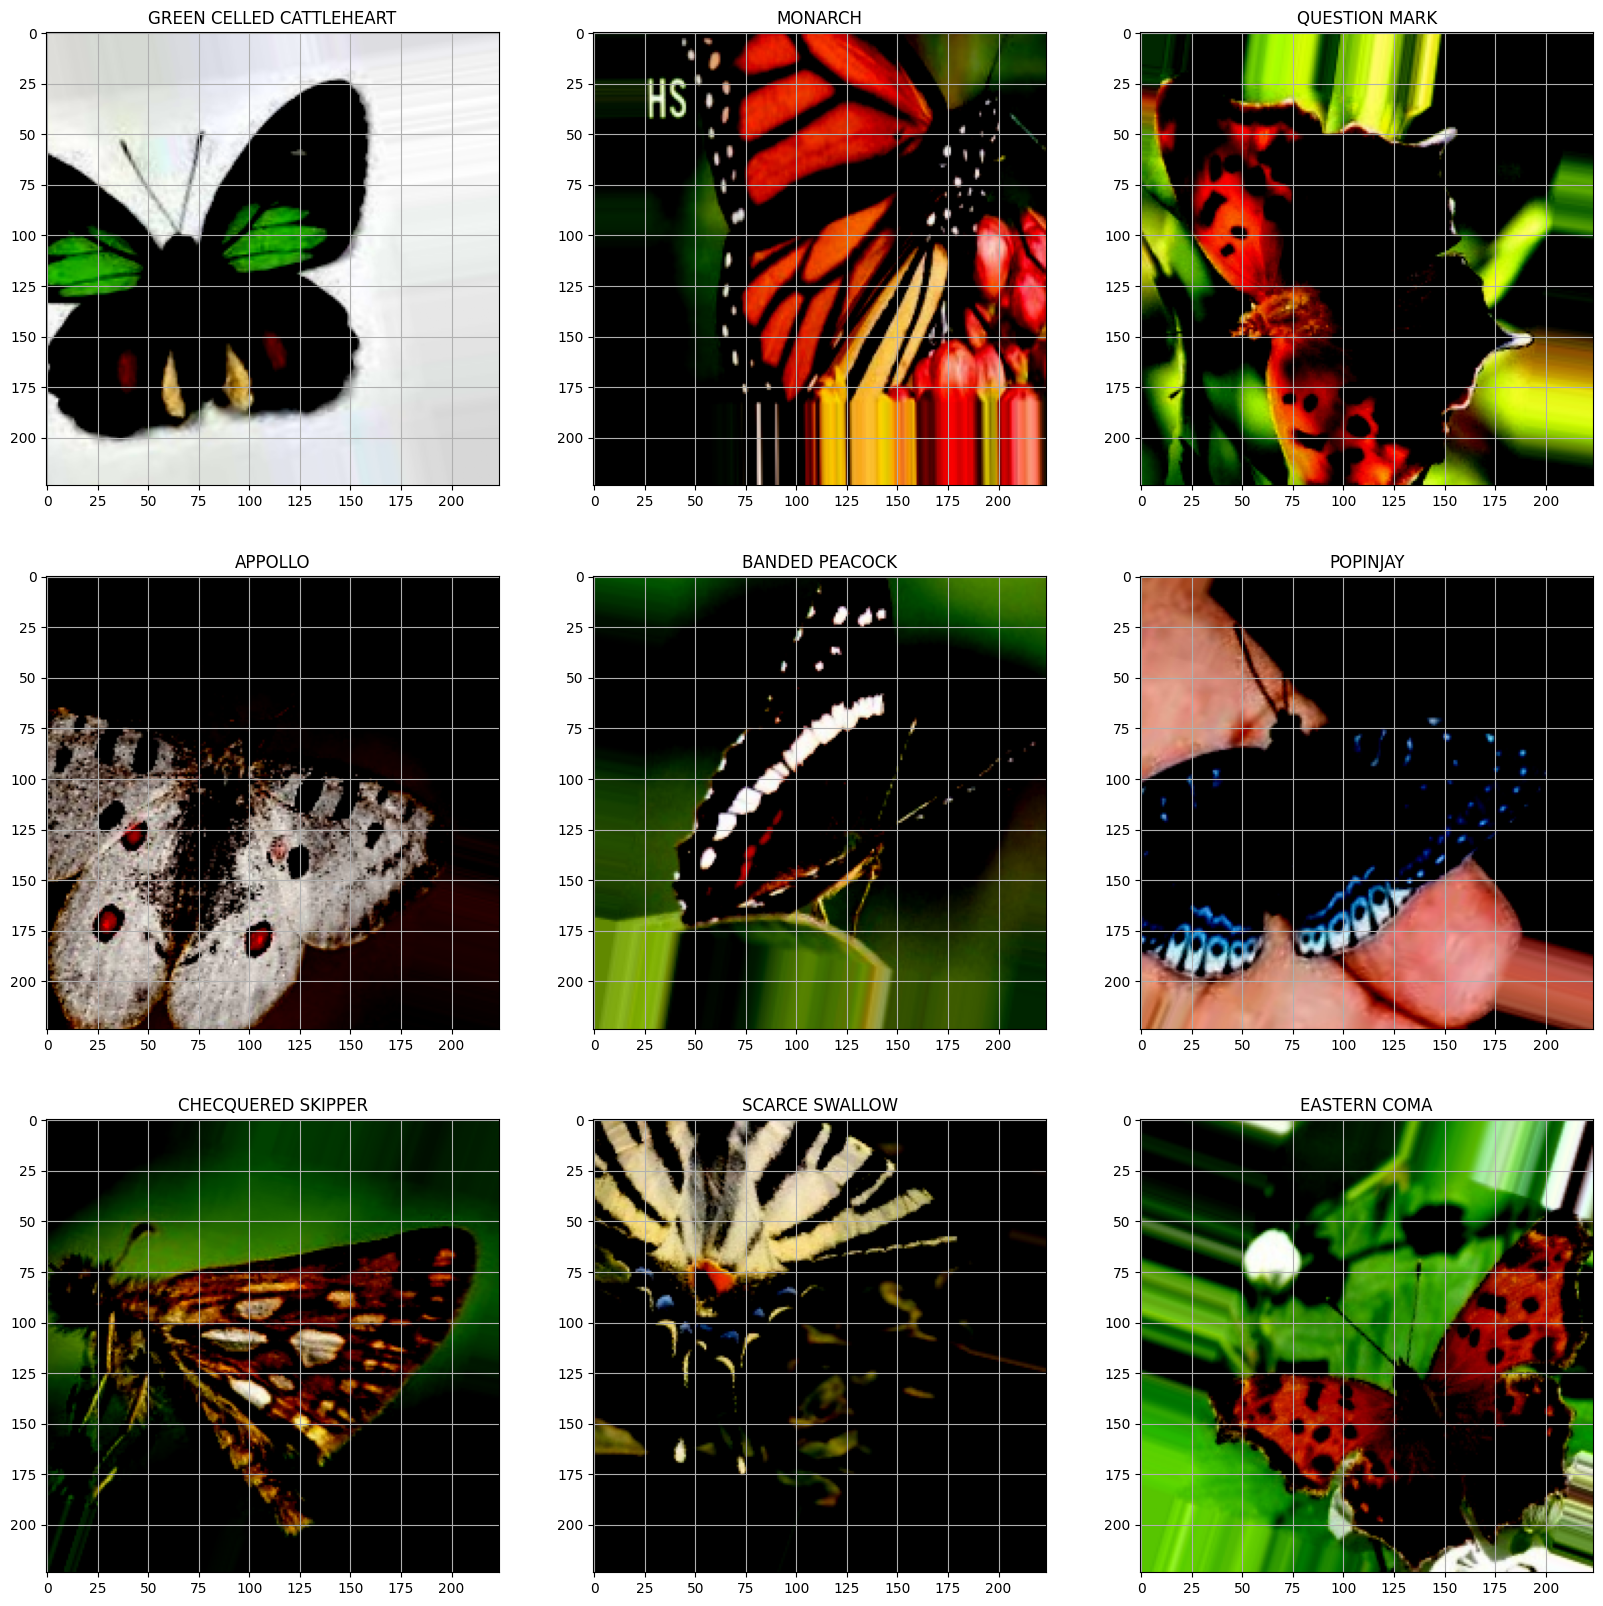

In [ ]:
classes=list(train_gen.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_gen:
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i],axis=-1)])
        plt.grid(None)
    plt.show()
    break

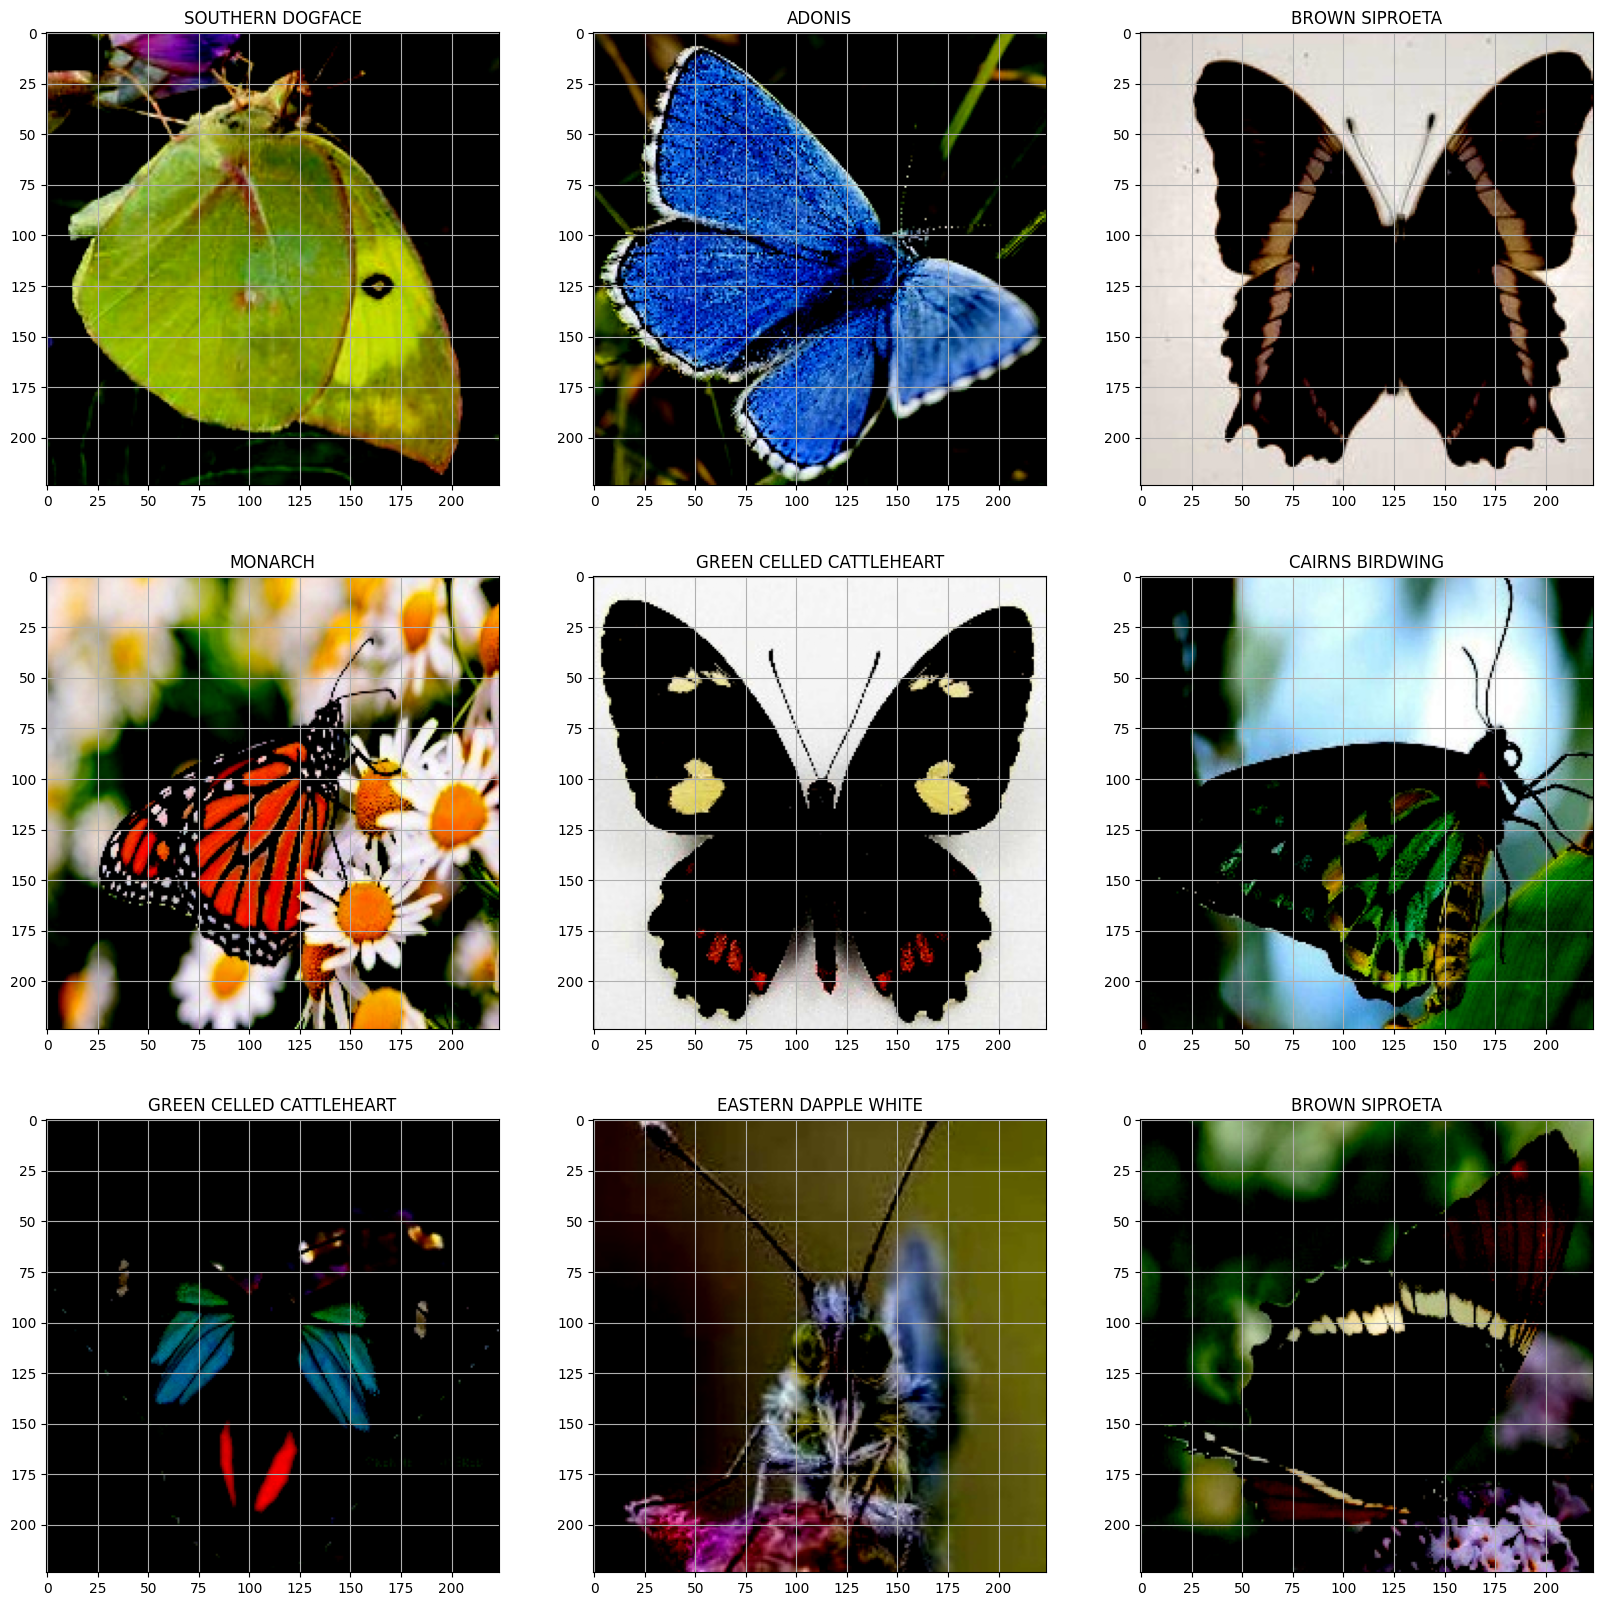

In [ ]:
classes=list(val_gen.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in val_gen:
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i],axis=-1)])
        plt.grid(None)
    plt.show()
    break

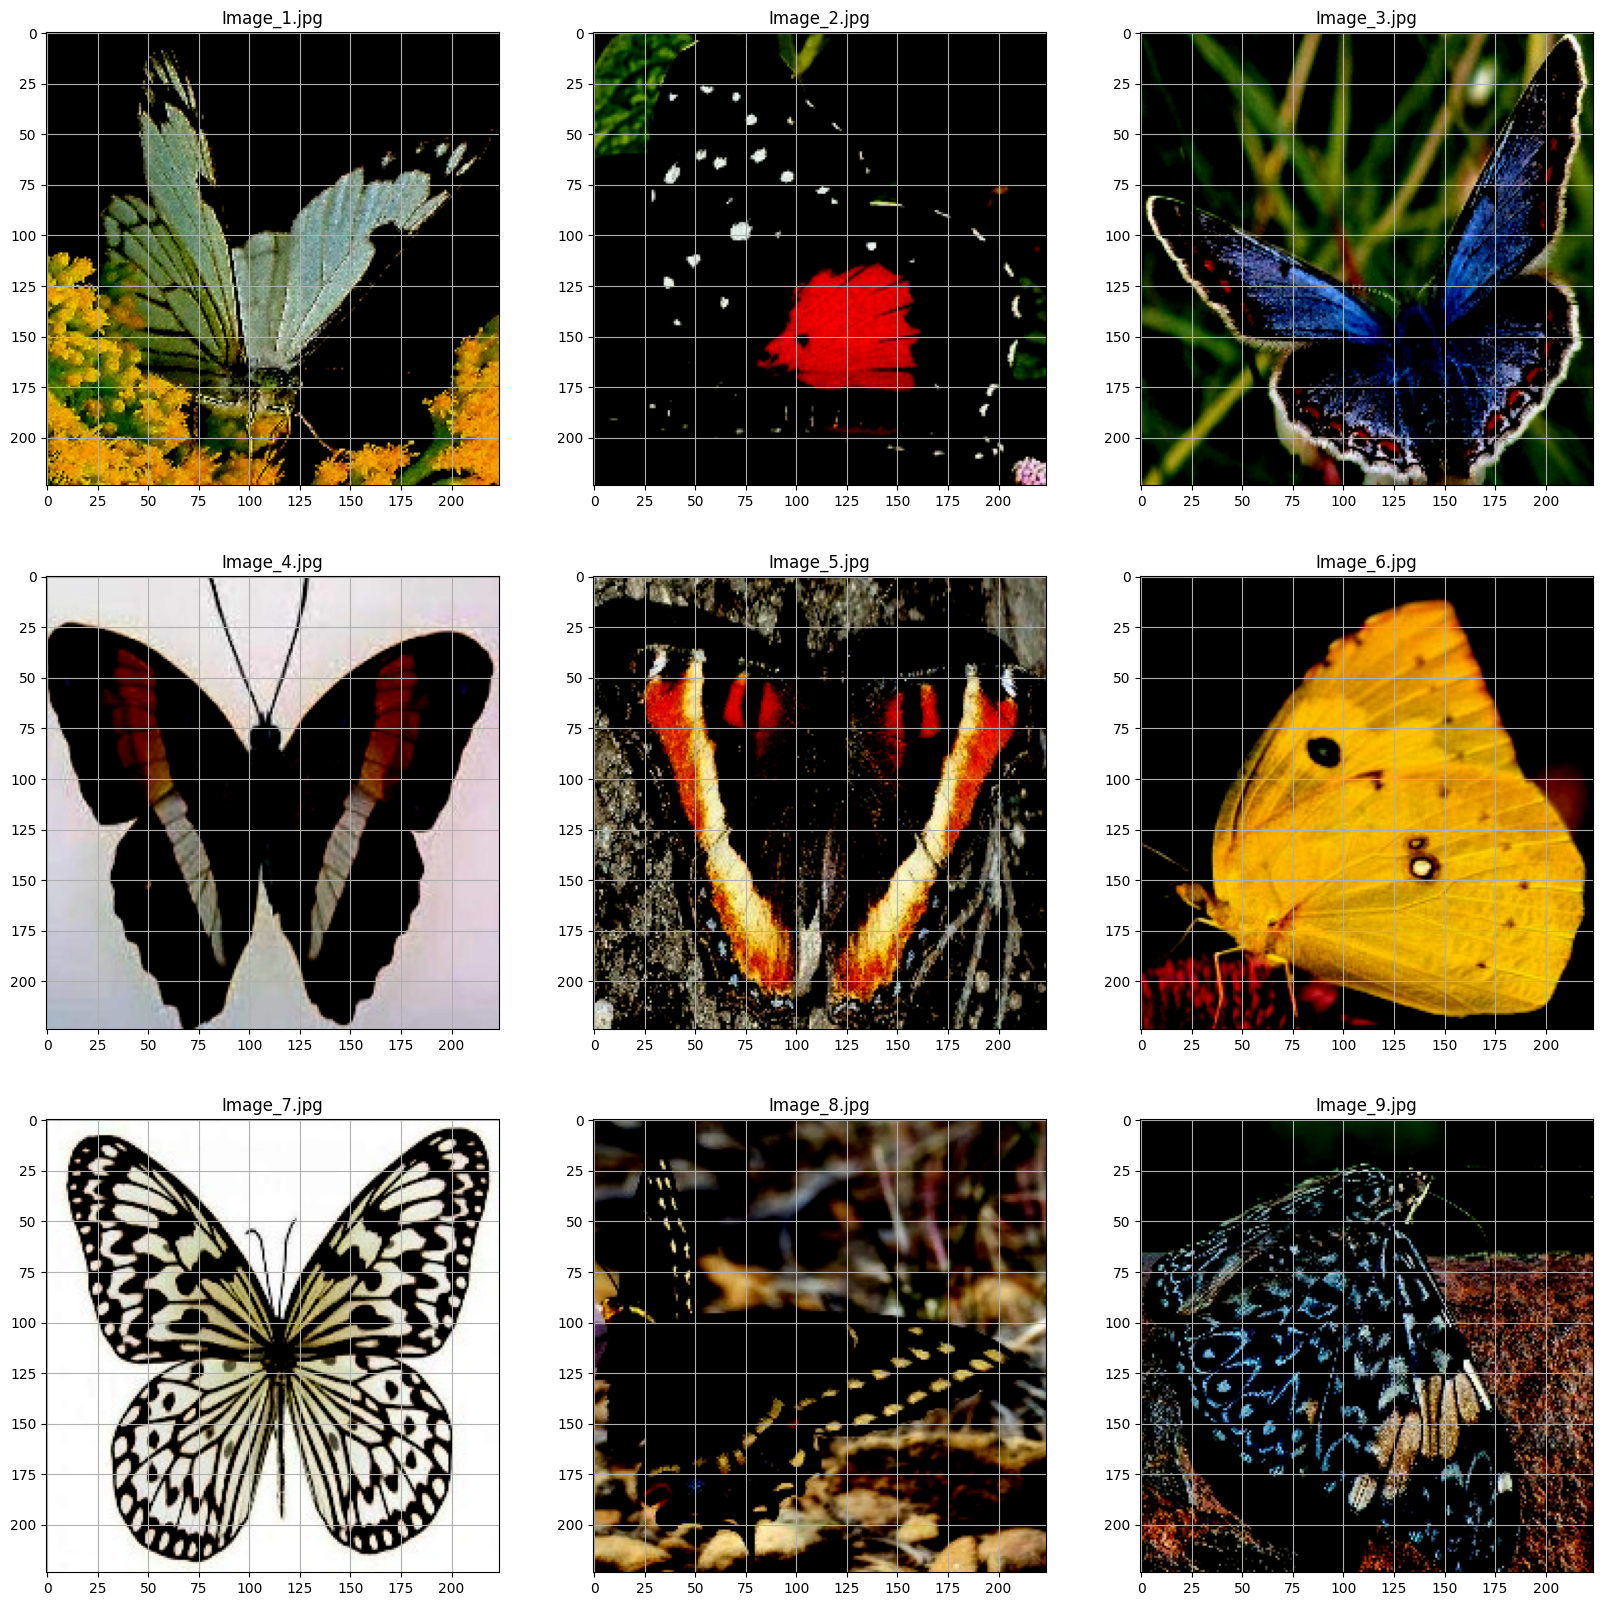

In [ ]:
plt.figure(figsize=(20,20))
X_batch = next(test_gen)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_batch[i])
    plt.title(test_df['filename'].iloc[i])
    plt.grid(None)
plt.show()

In [ ]:
num_classes = len(train_gen.class_indices)
num_classes

75

# Training the Model (CNN)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(size,size,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         1,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,411 (1.54 MB)

 Trainable params: 401,387 (1.53 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.keras',
    monitor='val loss',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    cooldown=2,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[earlystopping, checkpoint, reduce_lr]
)



Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 145s 651ms/step - accuracy: 0.0405 - loss: 4.1867 - val_accuracy: 0.0169 - val_loss: 4.5037 - learning_rate: 0.0010
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


183/183 ━━━━━━━━━━━━━━━━━━━━ 91s 494ms/step - accuracy: 0.0993 - loss: 3.7461 - val_accuracy: 0.0077 - val_loss: 4.5754 - learning_rate: 0.0010
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 488ms/step - accuracy: 0.1646 - loss: 3.3916 - val_accuracy: 0.0524 - val_loss: 4.0496 - learning_rate: 0.0010
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 489ms/step - accuracy: 0.2241 - loss: 3.0862 - val_accuracy: 0.2481 - val_loss: 3.0187 - learning_rate: 0.0010
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 493ms/step - accuracy: 0.2912 - loss: 2.7890 - val_accuracy: 0.2820 - val_loss: 2.8061 - learning_rate: 0.0010
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 488ms/step - accuracy: 0.3246 - loss: 2.5981 - val_accuracy: 0.3852 - val_loss: 2.2185 - learning_rate: 0.0010
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 91s 495ms/step - accuracy: 0.3620 - loss: 2.4142 - val_accuracy: 0.3914 - val_loss: 2.4010 - learning_rate: 0.0010
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 90s 490ms/step - accuracy: 0.3844 -

In [ ]:
model.save("butterfly_model_deeper_100epochs.keras")

In [ ]:
test_loss, test_acc = model.evaluate(val_gen)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7807 - loss: 0.7907
Test Accuracy: 0.76
Test Loss: 0.8607


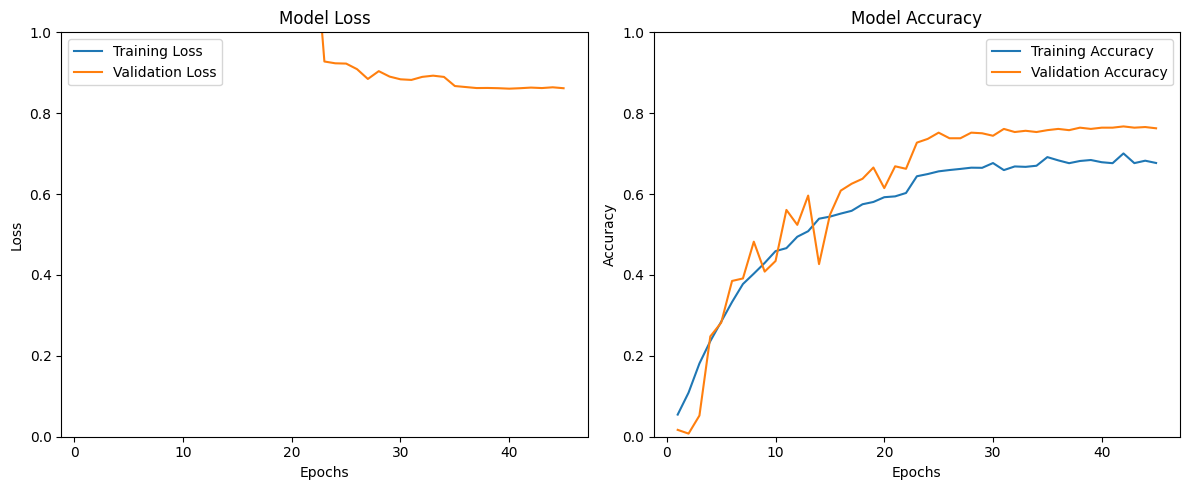

In [ ]:
epochs_ran = range(1, len(history.history['loss'])+1)

plt.figure(figsize=(12,5))

# -------- Loss Chart --------
plt.subplot(1,2,1)
plt.plot(epochs_ran, history.history['loss'], label='Training Loss')
plt.plot(epochs_ran, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim((0,1))

# -------- Accuracy Chart --------
plt.subplot(1,2,2)
plt.plot(epochs_ran, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_ran, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim((0,1))

plt.tight_layout()
plt.show()


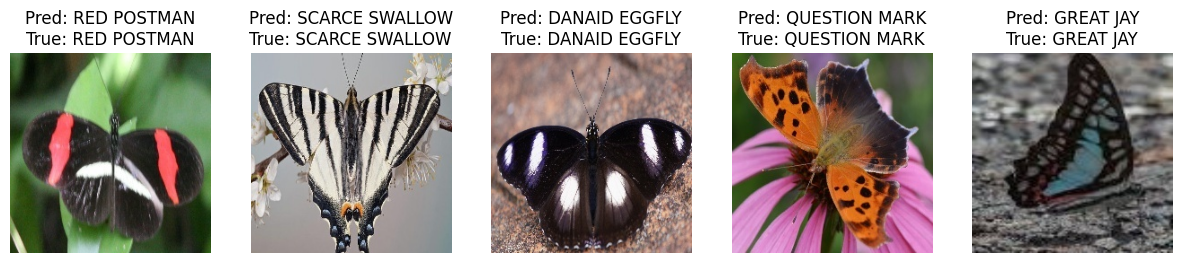

In [ ]:
num_samples = 5
X_batch, y_batch = next(val_gen)
batch_size = X_batch.shape[0]
indices = random.sample(range(batch_size), num_samples)

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = X_batch[idx]
    pred_probs = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred_probs, axis=1)[0]
    true_class = np.argmax(y_batch[idx])
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
    plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


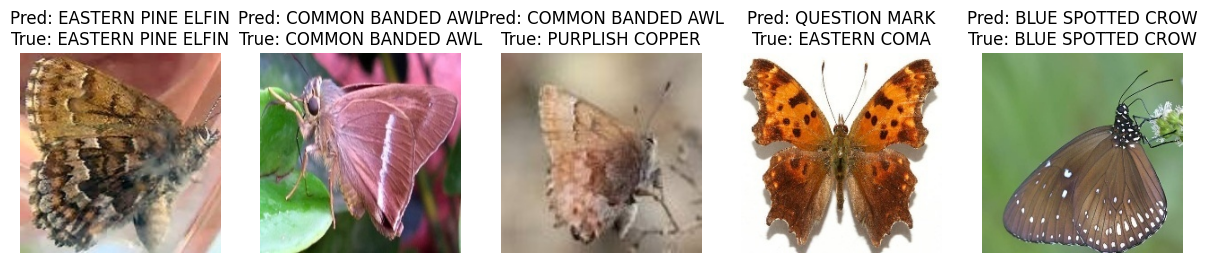

In [ ]:

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = X_batch[idx]
    pred_probs = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred_probs, axis=1)[0]
    true_class = np.argmax(y_batch[idx])

    class_labels = {v: k for k, v in val_gen.class_indices.items()}
    pred_label = class_labels[pred_class]
    true_label = class_labels[true_class]

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis('off')
plt.show()


# Training the Model (using Transfer Learning "pretrained model")

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(size,size,3))

In [ ]:
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
outputs=Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,109,643 (91.97 MB)

 Trainable params: 8,424,011 (32.14 MB)

 Non-trainable params: 15,685,632 (59.84 MB)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint('pretrained_model.keras', monitor='val_loss', save_best_only=True)
learningrate_schedular = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

In [ ]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[earlystopping, checkpoint, learningrate_schedular]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 123s 513ms/step - accuracy: 0.2729 - loss: 3.3786 - val_accuracy: 0.8428 - val_loss: 0.6536 - learning_rate: 1.0000e-04
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 90s 443ms/step - accuracy: 0.8325 - loss: 0.7639 - val_accuracy: 0.9245 - val_loss: 0.3122 - learning_rate: 1.0000e-04
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 91s 448ms/step - accuracy: 0.8930 - loss: 0.4618 - val_accuracy: 0.9414 - val_loss: 0.2122 - learning_rate: 1.0000e-04
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 92s 449ms/step - accuracy: 0.9191 - loss: 0.3315 - val_accuracy: 0.9630 - val_loss: 0.1548 - learning_rate: 1.0000e-04
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 88s 430ms/step - accuracy: 0.9506 - loss: 0.2327 - val_accuracy: 0.9723 - val_loss: 0.0969 - learning_rate: 1.0000e-04
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 88s 431ms/step - accuracy: 0.9511 - loss: 0.1966 - val_accuracy: 0.9723 - val_loss: 0.0673 - learning_rate: 1.0000e-04
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_acc = model.evaluate(val_gen)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 0.0057
Test Accuracy: 1.00
Test Loss: 0.0065


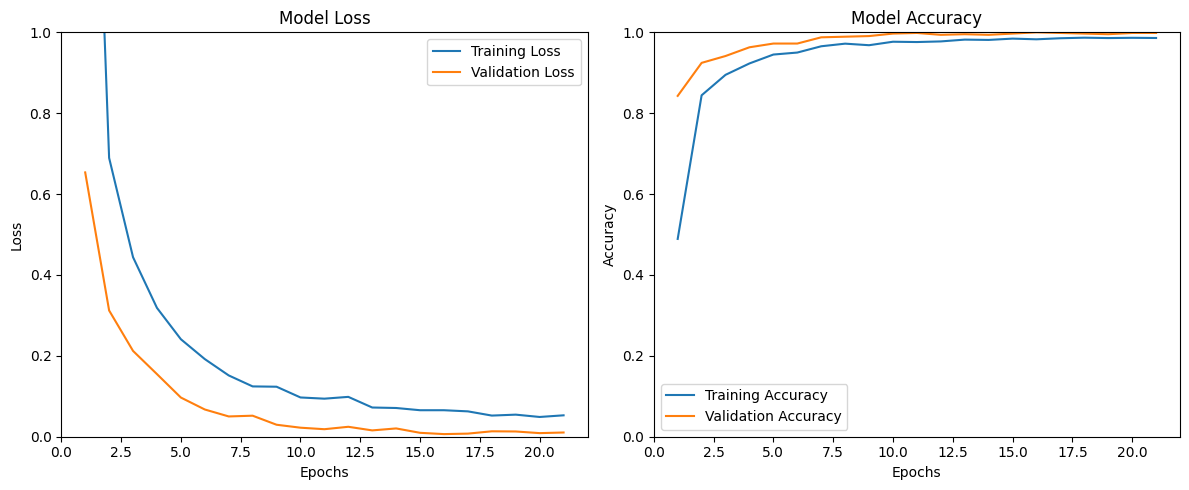

In [ ]:
epochs_ran = range(1, len(history.history['loss'])+1)

plt.figure(figsize=(12,5))

# -------- Loss Chart --------
plt.subplot(1,2,1)
plt.plot(epochs_ran, history.history['loss'], label='Training Loss')
plt.plot(epochs_ran, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim((0,1))

# -------- Accuracy Chart --------
plt.subplot(1,2,2)
plt.plot(epochs_ran, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_ran, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim((0,1))

plt.tight_layout()
plt.show()


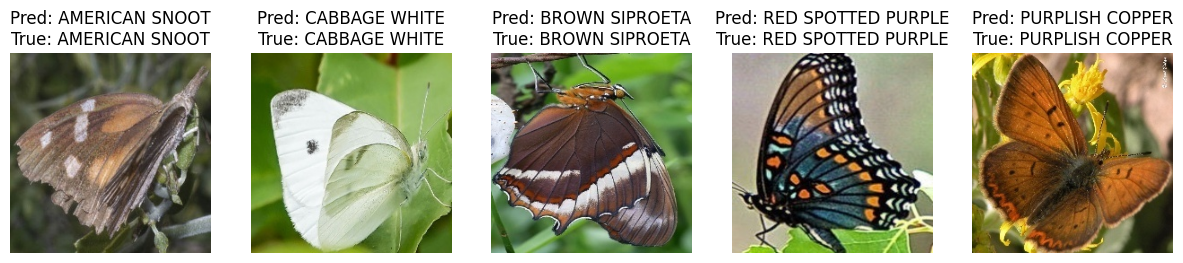

In [ ]:
num_samples = 5
X_batch, y_batch = next(val_gen)
batch_size = X_batch.shape[0]
indices = random.sample(range(batch_size), num_samples)
class_names = {v:k for k,v in train_gen.class_indices.items()}

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = X_batch[idx]
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0, 1)
    pred_probs = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_class = np.argmax(pred_probs, axis=1)[0]
    true_class = np.argmax(y_batch[idx])

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img_display)
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}")
    plt.axis('off')
plt.show()